MNISTST (5) augmentation -> CIFAR (5/epocaMNIST)
xresnet18
fit normal

In [1]:
from fastai.vision.all import *
from datetime import datetime
import torch
torch.cuda.is_available()

True

In [2]:
path = Path('/home/fredguth/.fastai/data/cifar10_mnist')

In [3]:
def label_func(f):
    return (str(f).split("_y")[1:][0][0])

def noise_func(f):
    return (str(f).split("_n")[1:][0][0])

In [4]:
def get_dls(task="CIFAR", size=64):
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   splitter  = IndexSplitter(list(range(10000))),
                   get_items = get_image_files,
                   get_y = label_func if (task == 'CIFAR') else noise_func,
                   batch_tfms= [*aug_transforms(size=size, min_scale=0.75), Normalize],
                   n_inp     = 1 )
    return dblock.dataloaders(path, num_workers=4)

In [5]:
class HeadBodyNetwork(Module):
    def __init__(self, head, body):
        self.head = head
        self. body = body
    def forward(self, x):
        return self.head(self.body(x))

In [6]:
def headbody_splitter(m): return L(m.head, m.body).map(params)

In [7]:
class RunMNIST(Callback):
    def after_epoch(self):  
        epoch = self.epoch
        backbone = copy(self.learn.model[0])
        head =  create_head(512,10)
        net = HeadBodyNetwork(head=head, body=backbone)
        l =Learner(
                           dls=get_dls(task="CIFAR"), 
                           model=net,
                           splitter=headbody_splitter,
                           loss_func=F.cross_entropy, 
                           metrics=accuracy, 
                           cbs=[CSVLogger(fname=f"results/ex3/cifar_after_mnist_e{epoch}.csv")])
        l.freeze()
        l.fit(5,0.002)

In [8]:
mnist_learner= cnn_learner(dls=get_dls(task="MNIST"), 
                           arch=xresnet18, 
                           pretrained=False, 
                           loss_func=F.cross_entropy, 
                           metrics=accuracy, 
                           cbs=[CSVLogger(fname=f"results/ex3/mnist.csv"), RunMNIST]
                          )

In [9]:
b = mnist_learner.dls.one_batch()

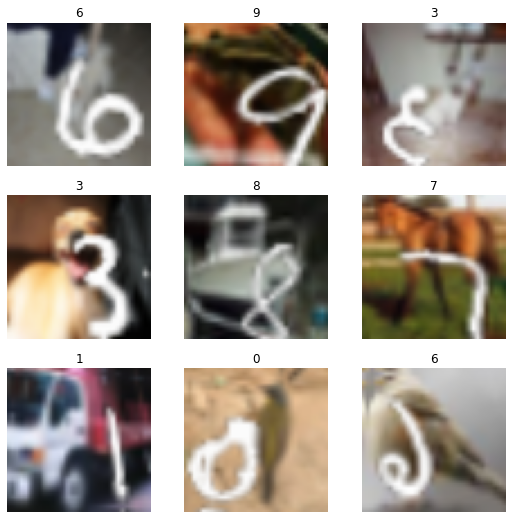

In [10]:
mnist_learner.dls.show_batch()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=9.12010818865383e-07)

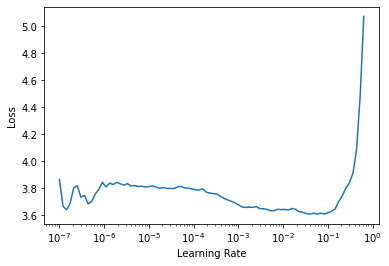

In [11]:
mnist_learner.lr_find()

In [12]:
mnist_learner.fit(5, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,0.492224,0.519570,0.858700,03:20
1,0.305664,0.375683,0.890400,04:21
2,0.218225,0.140177,0.955900,04:09
3,0.208261,0.129861,0.962100,04:01
4,0.170318,0.140171,0.956800,03:59


epoch,train_loss,valid_loss,accuracy,time
0,1.542513,1.394921,0.498100,00:29
1,1.299220,1.271888,0.551900,00:31
2,1.107844,1.062874,0.627600,00:32
3,0.994869,0.969448,0.665100,00:35
4,0.912972,0.939488,0.681800,00:39


epoch,train_loss,valid_loss,accuracy,time
0,1.367344,1.377664,0.524200,00:46
1,1.074186,1.020668,0.639800,00:39
2,0.912021,0.909387,0.687200,00:35
3,0.855539,0.822319,0.715800,00:44
4,0.808469,0.758726,0.740800,00:44


epoch,train_loss,valid_loss,accuracy,time
0,1.270971,1.108248,0.615300,00:39
1,0.936329,0.889902,0.697200,00:44
2,0.825140,0.787956,0.734400,00:38
3,0.757765,0.714741,0.756500,00:41
4,0.693159,0.684140,0.767300,00:42


epoch,train_loss,valid_loss,accuracy,time
0,1.200698,1.151612,0.609500,00:43
1,0.836843,0.889330,0.706900,00:38
2,0.704567,0.724601,0.762200,00:36
3,0.685613,0.668601,0.775000,00:44
4,0.659122,0.602269,0.798500,00:37


epoch,train_loss,valid_loss,accuracy,time
0,0.871290,0.863217,0.709700,00:44
1,0.701989,0.703007,0.766600,00:45
2,0.629906,0.622298,0.794000,00:37
3,0.581648,0.592234,0.802300,00:34
4,0.549627,0.579944,0.809000,00:37


In [13]:
import pandas as pd
import glob

In [14]:
!pwd

/home/fredguth/unb/cifar_mnist


In [22]:
all_files = glob.glob("/home/fredguth/unb/cifar_mnist/results/ex3/cifar*.csv")

In [23]:
all_files

['/home/fredguth/unb/cifar_mnist/results/ex3/cifar_after_mnist_e0.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex3/cifar_after_mnist_e2.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex3/cifar_after_mnist_e3.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex3/cifar_after_mnist_e1.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex3/cifar_after_mnist_e4.csv']

In [24]:
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

In [25]:
frame = pd.concat(li, axis=0, ignore_index=True)

In [26]:
mnist_results = frame.loc[frame['epoch'] == 4]

In [27]:
mnist_results

,epoch,train_loss,valid_loss,accuracy,time
4,4,0.912972,0.939488,0.6818,00:39
9,4,0.693159,0.684140,0.7673,00:42
14,4,0.659122,0.602269,0.7985,00:37
19,4,0.808469,0.758726,0.7408,00:44
24,4,0.549627,0.579944,0.8090,00:37


In [28]:
mnist_results = mnist_results.reset_index().drop(columns=['index', 'epoch'])

,train_loss,valid_loss,accuracy,time
0,0.912972,0.939488,0.6818,00:39
1,0.693159,0.684140,0.7673,00:42
2,0.659122,0.602269,0.7985,00:37
3,0.808469,0.758726,0.7408,00:44
4,0.549627,0.579944,0.8090,00:37


In [29]:
mnist_results.to_excel("results/ex3/ex3_cifar_results.xlsx")